## 1. data preparation

In [6]:
import pandas as pd
import os
import numpy as np
import spacy
from spacy import displacy
import nltk
from nltk.corpus import stopwords

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel

# from gensim.models.wrappers import LdaMallet

import matplotlib.pyplot as plt
import sklearn

my_stop_words = [
    "a",
    "an",
    "and",
    "are",
    "as",
    "at",
    "be",
    "by",
    "for",
    "from",
    "has",
    "he",
    "in",
    "is",
    "it",
    "of",
    "on",
    "or",
    "she",
    "that",
    "the",
    "to",
    "was",
    "were",
    "will",
    "with",
    "*",
    "**",
    "***",
    "µs",
]
default_stop_words = set(stopwords.words("english"))

stop_words = default_stop_words.union(my_stop_words)

Generate developer list of different group

In [7]:
# get the different developer set
developer_with_roles = pd.read_csv("../../outputs/results/developer_with_roles.csv")
issues_pytorch = pd.read_csv("../../data/raw/issues/pytorch.csv")
issues_tensorflow = pd.read_csv("../../data/raw/issues/tensorflow.csv")
pr_pytorch = issues_pytorch[issues_pytorch["issue_type"] == "pr"].reset_index(drop=True)
pr_pytorch["community"] = "pytorch"
pr_tensorflow = issues_tensorflow[issues_tensorflow["issue_type"] == "pr"].reset_index(
    drop=True
)
pr_tensorflow["community"] = "tensorflow"

In [8]:
# developers with core role in both communities
common_core_login = developer_with_roles[(developer_with_roles['pytorch_role'] == 'core') & (developer_with_roles['tensorflow_role'] == 'core')]['developer'].tolist()
# get common core pull request from pr_pytorch and pr_tensorflow
pr_pytorch_common_core = pr_pytorch[pr_pytorch['author'].isin(common_core_login)].reset_index(drop=True)
pr_tensorflow_common_core = pr_tensorflow[pr_tensorflow['author'].isin(common_core_login)].reset_index(drop=True)
# merge
pr_common_core = pd.concat([pr_pytorch_common_core, pr_tensorflow_common_core]).reset_index(drop=True)
pr_common_core.to_csv('../../outputs/results/pr_common_core.csv', index=False)
pr_common_core.to_excel('../../outputs/results/pr_common_core.xlsx', index=False)
pr_common_core

,issue_id,author,issue_type,timestamp,title,body,community
0,244,Maratyszcza,pr,2016-11-22T17:09:48Z,Make torch.backends.cudnn work on OSX,Tested on MBP with GeForce GT 750M,pytorch
1,1074,zuoxingdong,pr,2017-03-23T14:22:34Z,DataLoader: Fix batch data type for numpy array,The original code is reasonable under purpose ...,pytorch
2,1133,zuoxingdong,pr,2017-03-28T22:34:04Z,Add a flag to fix when dataset size is not div...,NaN,pytorch
3,1194,zuoxingdong,pr,2017-04-05T15:49:51Z,Fix AttributeError: module 'torch.utils' has n...,As @soumith replied in [Discuss Forum](https:/...,pytorch
4,2795,zuoxingdong,pr,2017-09-20T01:26:11Z,New features: parameters to vector and vector...,NaN,pytorch
...,...,...,...,...,...,...,...
2034,56480,kulinseth,pr,2022-06-16T14:23:14Z,Add macos_minimum_version to the bazelrc.,This passes the flag to clang for compilation ...,tensorflow
2035,56591,Flamefire,pr,2022-06-27T10:44:36Z,Fix interleave_test in CGroup restricted CPU envs,"Use `len(os.sched_getaffinity(0))`, which retu...",tensorflow
2036,56606,Flamefire,pr,2022-06-28T11:51:09Z,Link libdl in core/platform/default/stacktrace,~Required due to use of `dladdr` via the `stac...,tensorflow
2037,56633,Flamefire,pr,2022-06-30T09:57:15Z,Enhance NumSchedulableCPUs to allow for nodes ...,In systems with large core counts the default ...,tensorflow


In [9]:
# developers with core role in one of the two communities
py_one_side = developer_with_roles[(developer_with_roles['pytorch_role'] == 'core') & (developer_with_roles['tensorflow_role'] == 'peripheral')]['developer'].tolist()
ts_one_side = developer_with_roles[(developer_with_roles['pytorch_role'] == 'peripheral') & (developer_with_roles['tensorflow_role'] == 'core')]['developer'].tolist()
total_list = py_one_side + ts_one_side
# total_list
pr_pytorch_either_core = pr_pytorch[pr_pytorch['author'].isin(total_list)].reset_index(drop=True)
pr_tensorflow_either_core = pr_tensorflow[pr_tensorflow['author'].isin(total_list)].reset_index(drop=True)
# merge
pr_one_side_core = pd.concat([pr_pytorch_either_core, pr_tensorflow_either_core]).reset_index(drop=True)
pr_one_side_core.to_csv('../../outputs/results/pr_one_side_core.csv', index=False)
pr_one_side_core.to_excel('../../outputs/results/pr_one_side_core.xlsx', index=False)
pr_one_side_core

,issue_id,author,issue_type,timestamp,title,body,community
0,11,apaszke,pr,2016-09-07T17:20:21Z,"add multiprocessing unit tests, working file-d...","**Don't merge, this PR is only for test purpos...",pytorch
1,12,apaszke,pr,2016-09-07T17:20:55Z,Initial utils implementation + bug fixes,"**Don't merge, this PR is only for test purpos...",pytorch
2,24,apaszke,pr,2016-09-14T02:20:02Z,More modules for nn + improvements in CUDA tests,**Do not merge. This PR is just for review and...,pytorch
3,33,apaszke,pr,2016-09-15T20:04:11Z,Add more functions to autograd,**Do not merge. This PR is only for review and...,pytorch
4,34,apaszke,pr,2016-09-15T21:12:26Z,Various improvements and fixes,**Do not merge. This PR is only for review and...,pytorch
...,...,...,...,...,...,...,...
5510,56841,elfringham,pr,2022-07-20T14:48:40Z,Cache size is too small for machines with more...,The element size in this case is 363 bytes whi...,tensorflow
5511,56900,elfringham,pr,2022-07-26T10:08:21Z,Disable running of quantization_ops_test on AA...,This is a workaround until the issue #56861 ca...,tensorflow
5512,56924,nSircombe,pr,2022-07-27T15:20:01Z,Updates cpu_arm64_pip.sh to build with Eigen T...,https://github.com/tensorflow/tensorflow/pull/...,tensorflow
5513,56933,elfringham,pr,2022-07-28T11:14:46Z,Some unit tests are fixed and should be remove...,"Remove those unit tests that have been fixed, ...",tensorflow


In [10]:
# developers with peripheral role in both communities
both_peripheral_login = developer_with_roles[(developer_with_roles['pytorch_role'] == 'peripheral') & (developer_with_roles['tensorflow_role'] == 'peripheral')]['developer'].tolist()
# get common core pull request from pr_pytorch and pr_tensorflow
pr_pytorch_both_peripheral = pr_pytorch[pr_pytorch['author'].isin(both_peripheral_login)].reset_index(drop=True)
pr_tensorflow_both_peripheral = pr_tensorflow[pr_tensorflow['author'].isin(both_peripheral_login)].reset_index(drop=True)
# merge
pr_both_peripheral = pd.concat([pr_pytorch_both_peripheral, pr_tensorflow_both_peripheral]).reset_index(drop=True)
pr_both_peripheral.to_csv('../../outputs/results/pr_both_peripheral.csv', index=False)
pr_both_peripheral

,issue_id,author,issue_type,timestamp,title,body,community
0,255,jekbradbury,pr,2016-11-25T23:01:25Z,Fix batch_first in AutogradRNN,Fixes #253.,pytorch
1,490,vra,pr,2017-01-19T02:14:19Z,format fix,NaN,pytorch
2,502,ronrest,pr,2017-01-19T12:01:48Z,Update docstring for ConvTranspose functions,**Transposed convolutions** are often (*but in...,pytorch
3,503,ronrest,pr,2017-01-19T12:55:25Z,Update batchnorm docstrings,"Add missing full stops, and added blank line f...",pytorch
4,505,ronrest,pr,2017-01-19T13:43:43Z,Update docstrings for testing object type,Add docstring for `is_storage()` and `is_tenso...,pytorch
...,...,...,...,...,...,...,...
563,55726,code-review-doctor,pr,2022-04-24T21:14:46Z,Missing `f` prefix on f-strings fix,Fixes #55723,tensorflow
564,56354,cliffwoolley,pr,2022-06-03T23:21:28Z,Updated find_cuda_config.py.gz.base64,Now matches https://github.com/tensorflow/tens...,tensorflow
565,56392,cliffwoolley,pr,2022-06-07T16:22:59Z,[TF-TRT] Simplify redundant TensorRT version s...,Most of the library stubs for various TensorRT...,tensorflow
566,56627,rainwoodman,pr,2022-06-29T20:35:38Z,Describe `tf.squeeze`'s None shape behavior.,NaN,tensorflow


## 2. Spatial Similarity Analysis

- This aspect of spatial similarity analysis relies on comparing the titles and descriptions of PRs. The similarity is determined by calculating the cosine similarity of the TF-IDF vectors associated with the PR titles and descriptions.

- The ultimate determination of whether they are similar or not is based on manually reviewing the PRs that exhibit similarity.

### 2.1 Spatial Similarity Analysis of developers with core role in both communities.

In [11]:
from nltk.tokenize import word_tokenize
text_description_common_core = pr_common_core['body'].values.tolist()
text_description_common_core = [str(t) for t in text_description_common_core]
text_description_common_core = [t for t in text_description_common_core if t != 'nan']
text_description_common_core = [t for t in text_description_common_core if t != 'None']

In [12]:
text_title_common_core = pr_common_core['title'].values.tolist()
text_title_common_core = [str(t) for t in text_title_common_core]
text_title_common_core = [t for t in text_title_common_core if t != 'nan']
text_title_common_core = [t for t in text_title_common_core if t != 'None']

In [13]:
pr_common_core = pr_common_core[pr_common_core['body'].isin(text_description_common_core)].reset_index(drop=True)
pr_common_core = pr_common_core[pr_common_core['title'].isin(text_title_common_core)].reset_index(drop=True)
pr_common_core

,issue_id,author,issue_type,timestamp,title,body,community
0,244,Maratyszcza,pr,2016-11-22T17:09:48Z,Make torch.backends.cudnn work on OSX,Tested on MBP with GeForce GT 750M,pytorch
1,1074,zuoxingdong,pr,2017-03-23T14:22:34Z,DataLoader: Fix batch data type for numpy array,The original code is reasonable under purpose ...,pytorch
2,1194,zuoxingdong,pr,2017-04-05T15:49:51Z,Fix AttributeError: module 'torch.utils' has n...,As @soumith replied in [Discuss Forum](https:/...,pytorch
3,4548,ppwwyyxx,pr,2018-01-09T01:00:40Z,Fix type check in `checked_cast`.,`type.toBackend(toSparse(t.type().backend()))`...,pytorch
4,6282,Maratyszcza,pr,2018-04-04T22:29:22Z,[caffe2] Do not print version and build info u...,All Caffe2-enabled binaries print very verbose...,pytorch
...,...,...,...,...,...,...,...
1845,56480,kulinseth,pr,2022-06-16T14:23:14Z,Add macos_minimum_version to the bazelrc.,This passes the flag to clang for compilation ...,tensorflow
1846,56591,Flamefire,pr,2022-06-27T10:44:36Z,Fix interleave_test in CGroup restricted CPU envs,"Use `len(os.sched_getaffinity(0))`, which retu...",tensorflow
1847,56606,Flamefire,pr,2022-06-28T11:51:09Z,Link libdl in core/platform/default/stacktrace,~Required due to use of `dladdr` via the `stac...,tensorflow
1848,56633,Flamefire,pr,2022-06-30T09:57:15Z,Enhance NumSchedulableCPUs to allow for nodes ...,In systems with large core counts the default ...,tensorflow


In [14]:
tokens = [word_tokenize(t) for t in text_description_common_core]

In [15]:
# filtered_tokens = [[w.lower() for w in t if w.lower() not in stop_words] for t in tokens]
filtered_tokens = [[w.lower() for w in t if w.lower() not in stop_words and (w.isalpha() )] for t in tokens]
# rejoin the token in filter_tokens
filtered_tokens = [' '.join(t) for t in filtered_tokens]
filtered_tokens

['tested mbp geforce gt',
 'original code reasonable purpose without importing numpy however cases user shall generate data set using numpy often labels type gives true type label purpose line raise runtime error since label array used',
 'soumith replied discuss forum https solved adding import however many tutorials examples already directly call import torch pr fix need',
 'tosparse crash type matching sparse type half type sparse support',
 'binaries print verbose version information initialization fix disables unless explicitly requested via flag',
 'started option use nnpack system option mostly legacy include nnpack build platforms due problems nnpack built different dependencies compiler options decided remove option alwyas build nnpack change makes always build nnpack part build updates nnpack cpuinfo submodules',
 'enable use fused functionality nnpack',
 'tell nnpack link pthreadpool headers remove longer used',
 'adapted pthreadpool unit test',
 'integration creates blobs p

In [16]:
from gensim import  corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import re
custom_stopwords = STOPWORDS.union(set(stop_words))

documents = text_description_common_core
non_alphabetic_pattern = re.compile(r'[^a-zA-Z]')
# exclude the words in stopwords set of the documents
tokens = [[word for word in document.lower().split() if word not in custom_stopwords and not non_alphabetic_pattern.match(word)] for document in documents]
# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in tokens:
    for token in text:
        frequency[token] += 1
        
tokens = [[token for token in text if frequency[token] > 1] for text in tokens]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)
topics = lda_model.print_topics(num_words=5)

for topic in topics:
    print(topic)

(0, '0.033*"merge]" + 0.033*"debug" + 0.026*"mac" + 0.023*"os" + 0.015*"file"')
(1, '0.019*"add" + 0.014*"stack" + 0.014*"test" + 0.013*"support" + 0.012*"cuda"')
(2, '0.019*"import" + 0.011*"code" + 0.009*"test" + 0.008*"sparsity" + 0.008*"def"')
(3, '0.021*"benchmark" + 0.020*"add" + 0.017*"instruction" + 0.016*"count" + 0.011*"migrate"')
(4, '0.061*"differential" + 0.060*"revision:" + 0.058*"stack" + 0.027*"quantized" + 0.014*"changes"')
(5, '0.041*"fixes" + 0.012*"number}" + 0.011*"files" + 0.010*"revision:" + 0.010*"differential"')
(6, '0.014*"use" + 0.009*"error" + 0.009*"test" + 0.008*"file" + 0.007*"def"')
(7, '0.050*"size:" + 0.025*"embedding" + 0.025*"tokens:" + 0.025*"hidden" + 0.014*"support"')
(8, '0.097*"loop" + 0.089*"runs," + 0.089*"dev." + 0.089*"std." + 0.089*"each)"')
(9, '0.024*"test" + 0.014*"revision:" + 0.014*"differential" + 0.010*"summary:" + 0.010*"time"')


In [17]:
# 词频统计
from collections import Counter
from collections import Counter
words = []
for text in tokens:
    words.extend(text)
word_count = Counter(words)
word_count.most_common(30)

[('loop', 824),
 ('runs,', 756),
 ('std.', 755),
 ('dev.', 755),
 ('each)', 755),
 ('loops', 701),
 ('differential', 611),
 ('revision:', 607),
 ('stack', 599),
 ('test', 468),
 ('pr', 359),
 ('fixes', 353),
 ('add', 349),
 ('ms', 349),
 ('ns', 330),
 ('file', 265),
 ('use', 237),
 ('support', 217),
 ('line', 207),
 ('tests', 199),
 ('import', 188),
 ('cuda', 178),
 ('python', 174),
 ('new', 169),
 ('benchmark', 169),
 ('code', 167),
 ('tensor', 164),
 ('size:', 162),
 ('quantized', 160),
 ('plan:', 158)]

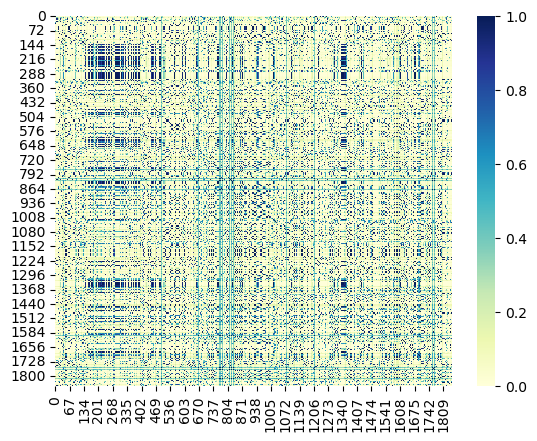

In [18]:
# similarity calculation
import seaborn as sns
from gensim import similarities
index = similarities.MatrixSimilarity(lda_model[corpus])
sims = index[lda_model[corpus]]
sims = np.array(sims)
sns.heatmap(sims, cmap="YlGnBu")
plt.show()

/home/yunqichen/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


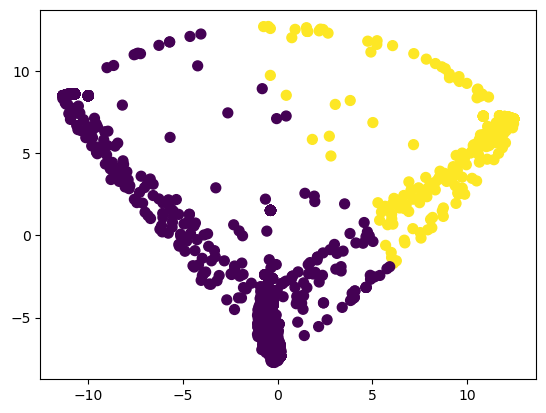

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.decomposition import PCA

# 1. Dimensionality Reduction
pca = PCA(n_components=3)
pca.fit(sims)
X = pca.transform(sims)
# 2. Clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_
# 3. Plotting
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap="viridis")
plt.show()

### 2.2 Spatial Similarity Analysis of developers with core role in one of the two communities

In [16]:
from nltk.tokenize import word_tokenize

text_description_oneside_core = pr_one_side_core["body"].values.tolist()
text_description_oneside_core = [str(t) for t in text_description_oneside_core]
text_description_oneside_core = [t for t in text_description_oneside_core if t != "nan"]
text_description_oneside_core = [
    t for t in text_description_oneside_core if t != "None"
]

text_title_oneside_core = pr_one_side_core["title"].values.tolist()
text_title_oneside_core = [str(t) for t in text_title_oneside_core]
text_title_oneside_core = [t for t in text_title_oneside_core if t != "nan"]
text_title_oneside_core = [t for t in text_title_oneside_core if t != "None"]

pr_one_side_core = pr_one_side_core[
    pr_one_side_core["body"].isin(text_description_oneside_core)
].reset_index(drop=True)
pr_one_side_core = pr_one_side_core[
    pr_one_side_core["title"].isin(text_title_oneside_core)
].reset_index(drop=True)
pr_one_side_core

,issue_id,author,issue_type,timestamp,title,body,community
0,664,thuyen,pr,2017-02-01T02:20:12Z,ByteTensor should be unsigned,Just little fix to the docs,pytorch
1,1047,jihunchoi,pr,2017-03-20T13:19:46Z,Correct typo in batchnorm documentation,"When applying batchnorm, the second dimension ...",pytorch
2,1408,peterjc123,pr,2017-04-30T06:44:26Z,added nadam optimizer,The PR added the new optimizer of Nadam. I wro...,pytorch
3,1704,taion,pr,2017-06-02T18:53:54Z,Improve README copyediting,I apologize in advance for how dumb this is. I...,pytorch
4,1786,peterjc123,pr,2017-06-13T04:58:16Z,Improve Windows Compatibility,Improves Windows Compatibility by modifying th...,pytorch
...,...,...,...,...,...,...,...
1694,55838,duncanriach,pr,2022-05-02T22:29:41Z,Rename IsCudnnSupportedFilterSize for grouped ...,This PR is a follow-up to [this discussion](ht...,tensorflow
1695,55875,duncanriach,pr,2022-05-04T00:54:51Z,Fix swapped cuda and cuDNN versions,It seems clear to me that the cuda and cuDNN v...,tensorflow
1696,56154,cloudhan,pr,2022-05-18T11:34:46Z,Unbreak windows build,Address two build problem when building jaxlib...,tensorflow
1697,56790,nSircombe,pr,2022-07-15T15:55:40Z,Updates Compute Library version to 22.05 and a...,- Changes to workspace2.bzl to download the v2...,tensorflow


In [24]:
author_list = pr_one_side_core['author'].unique().tolist()
author_list

['thuyen',
 'jihunchoi',
 'peterjc123',
 'taion',
 'rdipietro',
 'MicaelCarvalho',
 'rasbt',
 'vfdev-5',
 'gokceneraslan',
 'malmaud',
 'orionr',
 'bstriner',
 'Yangqing',
 'superbobry',
 'facaiy',
 'syed-ahmed',
 'Randl',
 'LaurentMazare',
 'musikisomorphie',
 'bharatr21',
 'lutzroeder',
 'ThisIsIsaac',
 'yanboliang',
 'cloudhan',
 'alanhdu',
 'gaurav1086',
 'lezcano',
 'duncanriach',
 'yaochengji',
 'hgaiser',
 'r-barnes',
 'zhuzilin',
 'TylerADavis',
 'nSircombe',
 'silvasean',
 'eqy',
 'wangkuiyi',
 'bryant1410',
 'tillahoffmann',
 'nkreeger',
 'chrisyeh96',
 'b0noI',
 'suphoff',
 'jaketae',
 'ziky90',
 'joker-eph',
 'AdityaKane2001',
 'alsrgv']

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
def calculate_similarity(author_name, pr_one_side_core):
    vectorizer = TfidfVectorizer()
    
    # caculate title similarity
    title_text_all = pr_one_side_core['title'].values.tolist()
    title_text_all = [str(t) for t in title_text_all]
    title_group1 = pr_one_side_core[pr_one_side_core['community'] == 'pytorch']['title'].values.tolist()
    title_group1 = [str(t) for t in title_group1]
    title_group2 = pr_one_side_core[pr_one_side_core['community'] == 'tensorflow']['title'].values.tolist()
    title_group2 = [str(t) for t in title_group2]
    tfidf_matrix = vectorizer.fit_transform(title_text_all)
    title_similarity_matrix =cosine_similarity(tfidf_matrix)
    title_similarity_value = title_similarity_matrix[:len(title_group1), len(title_group1):].mean()
    
    # caculate the body similarity
    body_text_all = pr_one_side_core['body'].values.tolist()
    body_text_all = [str(t) for t in body_text_all]
    
    body_group1 = pr_one_side_core[pr_one_side_core['community'] == 'pytorch']['body'].values.tolist()
    body_group1 = [str(t) for t in body_group1]
    body_group2 = pr_one_side_core[pr_one_side_core['community'] == 'tensorflow']['body'].values.tolist()
    body_group2 = [str(t) for t in body_group2]
    tfidf_matrix = vectorizer.fit_transform(body_text_all)
    body_similarity_matrix =cosine_similarity(tfidf_matrix)
    body_similarity_value = body_similarity_matrix[:len(body_group1), len(body_group1):].mean()
    
    return title_similarity_value, body_similarity_value

In [26]:
result_df = pd.DataFrame(columns=['author','title_similarity_value' ])
for author in author_list:
    try:
        title_similarity_value, body_similarity_value = calculate_similarity(author, pr_one_side_core[pr_one_side_core['author'] == author])
        print(author, title_similarity_value, body_similarity_value)
        result_df = result_df.append({'author': author, 'title_similarity_value': title_similarity_value, 'body_similarity_value': body_similarity_value}, ignore_index=True)
    except Exception as e:
        # print(e)
        print(author)
        continue

thuyen 0.03636598143224317 0.05726795438180608
thuyen
jihunchoi 0.024314220285830388 0.10827832837057506
jihunchoi
peterjc123 0.024654831484119684 0.047897748349103944
peterjc123
taion 0.0 0.011006211493040605
taion
rdipietro 0.06724379605430042 0.09633006858789839
rdipietro
MicaelCarvalho 0.0 0.10658554987590547
MicaelCarvalho
rasbt 0.04278524235328611 0.08154042632702034
rasbt
vfdev-5 0.06426248855405849 0.0010390445262135198
vfdev-5
gokceneraslan 0.011747481988274692 0.029075743726908364
gokceneraslan
malmaud 0.055477204497716585 0.06298094559533472
malmaud
orionr 0.031065422372360273 0.036465990798705925
orionr
bstriner 0.029625913326781154 0.08912898347797141
bstriner
Yangqing nan nan
Yangqing
superbobry 0.04965784240922518 0.05605415123699413
superbobry
facaiy 0.05778010045585243 0.03837179057606455
facaiy
syed-ahmed 0.018992846573289056 0.049548686975195586
syed-ahmed
Randl 0.01618397204173844 0.04530212297714991
Randl
LaurentMazare 0.04180612761402632 0.11261525560851883
Lauren

/tmp/ipykernel_7418/347026632.py:15: RuntimeWarning: Mean of empty slice.
  title_similarity_value = title_similarity_matrix[:len(title_group1), len(title_group1):].mean()
/home/yunqichen/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_7418/347026632.py:27: RuntimeWarning: Mean of empty slice.
  body_similarity_value = body_similarity_matrix[:len(body_group1), len(body_group1):].mean()


nSircombe 0.12986495640876244 0.1918979132310368
nSircombe
silvasean 0.030226381522906492 0.05299831768759137
silvasean
eqy nan nan
eqy
wangkuiyi nan nan
wangkuiyi
bryant1410 0.02807287341163295 0.0913464940486511
bryant1410
tillahoffmann 0.03814420682237841 0.10293420262894623
tillahoffmann
nkreeger 0.016593579497513174 0.07739970150927192
nkreeger
chrisyeh96 0.0399661226485991 0.007924797205769234
chrisyeh96
b0noI 0.02371682123730388 0.05517279211392195
b0noI
suphoff 0.02307369172373297 0.0746025749096839
suphoff
jaketae 0.024194386721235476 0.014894887814674755
jaketae
ziky90 0.04037571011677317 0.0730339685422144
ziky90
joker-eph 0.0 0.12210086598829256
joker-eph
AdityaKane2001 0.12072783208252981 0.0
AdityaKane2001
alsrgv nan nan
alsrgv


In [23]:
pr_one_side_core['author'].unique().tolist()

['thuyen',
 'jihunchoi',
 'peterjc123',
 'taion',
 'rdipietro',
 'MicaelCarvalho',
 'rasbt',
 'vfdev-5',
 'gokceneraslan',
 'malmaud',
 'orionr',
 'bstriner',
 'Yangqing',
 'superbobry',
 'facaiy',
 'syed-ahmed',
 'Randl',
 'LaurentMazare',
 'musikisomorphie',
 'bharatr21',
 'lutzroeder',
 'ThisIsIsaac',
 'yanboliang',
 'cloudhan',
 'alanhdu',
 'gaurav1086',
 'lezcano',
 'duncanriach',
 'yaochengji',
 'hgaiser',
 'r-barnes',
 'zhuzilin',
 'TylerADavis',
 'nSircombe',
 'silvasean',
 'eqy',
 'wangkuiyi',
 'bryant1410',
 'tillahoffmann',
 'nkreeger',
 'chrisyeh96',
 'b0noI',
 'suphoff',
 'jaketae',
 'ziky90',
 'joker-eph',
 'AdityaKane2001',
 'alsrgv']

In [23]:
custom_stopwords = STOPWORDS.union(set(stop_words))

documents = text_description_oneside_core
non_alphabetic_pattern = re.compile(r'[^a-zA-Z]')
# exclude the words in stopwords set of the documents
tokens = [[word for word in document.lower().split() if word not in custom_stopwords and not non_alphabetic_pattern.match(word)] for document in documents]
# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in tokens:
    for token in text:
        frequency[token] += 1
        
tokens = [[token for token in text if frequency[token] > 1] for text in tokens]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=10)
topics = lda_model.print_topics(num_words=5)

for topic in topics:
    print(topic)

(0, '0.033*"loop" + 0.026*"std." + 0.026*"each)" + 0.026*"dev." + 0.026*"runs,"')
(1, '0.025*"model" + 0.021*"results" + 0.020*"task" + 0.019*"false" + 0.017*"const"')
(2, '0.118*"bandwidth" + 0.118*"forward" + 0.117*"elements" + 0.116*"size," + 0.018*"cauchy,"')
(3, '0.121*"shape" + 0.014*"torch.size([1," + 0.014*"torch.size([4," + 0.014*"torch.size([16," + 0.014*"torch.size([2,"')
(4, '0.043*"threads:" + 0.031*"torch.float32" + 0.031*"times" + 0.024*"contiguous" + 0.023*"cuda"')
(5, '0.067*"fixes" + 0.021*"file" + 0.021*"cc" + 0.017*"line" + 0.012*"pr"')
(6, '0.061*"differential" + 0.061*"revision:" + 0.031*"test" + 0.026*"summary:" + 0.023*"plan:"')
(7, '0.026*"pr" + 0.020*"fix" + 0.018*"add" + 0.013*"test" + 0.012*"cc"')
(8, '0.113*"jan" + 0.040*"doc:" + 0.032*"long\')" + 0.027*"comparison" + 0.027*"different"')
(9, '0.063*"stride" + 0.018*"pr" + 0.017*"stack" + 0.008*"add" + 0.008*"cc"')


In [24]:
from collections import Counter
from collections import Counter
words = []
for text in tokens:
    words.extend(text)
word_count = Counter(words)
word_count.most_common(30)

[('forward', 552),
 ('bandwidth', 515),
 ('elements', 511),
 ('size,', 509),
 ('pr', 438),
 ('jan', 415),
 ('differential', 406),
 ('revision:', 406),
 ('shape', 371),
 ('test', 358),
 ('fixes', 340),
 ('cc', 258),
 ('loop', 233),
 ('fix', 215),
 ('cuda', 210),
 ('stride', 192),
 ('tests', 184),
 ('use', 183),
 ('summary:', 179),
 ('add', 164),
 ('stack', 164),
 ('cpu', 158),
 ('current', 157),
 ('threads:', 154),
 ('std.', 153),
 ('dev.', 152),
 ('runs,', 152),
 ('each)', 152),
 ('added', 148),
 ('doc:', 146)]

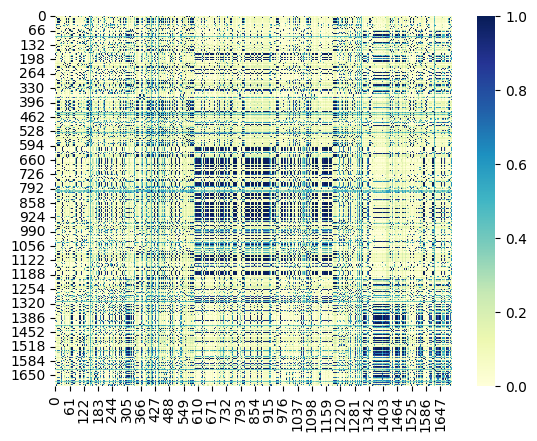

In [25]:
from gensim import similarities
index = similarities.MatrixSimilarity(lda_model[corpus])
sims = index[lda_model[corpus]]
sims = np.array(sims)
sns.heatmap(sims, cmap="YlGnBu")
plt.show()

In [26]:
# make sims from array to dataframe
df = pd.DataFrame(sims)
# only save the right triangle value
df = df.where(np.triu(np.ones(df.shape)).astype(np.bool))
# get the index of the max value


/tmp/ipykernel_24081/4090415048.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df = df.where(np.triu(np.ones(df.shape)).astype(np.bool))


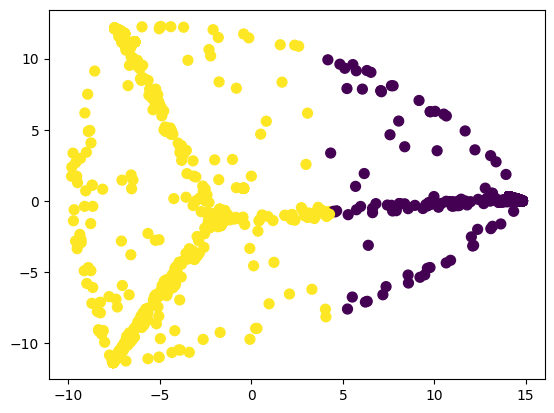

In [27]:
# 1. 降维
pca = PCA(n_components=2)
pca.fit(sims)
X = pca.transform(sims)
# 2. 聚类
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_
# 3. 画图
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.show()

In [28]:
# 得到数目最大的那一组pullrequest
pr_one_side_core['label'] = labels
pr_one_side_core[pr_one_side_core['label'] == 0]

,issue_id,author,issue_type,timestamp,title,body,label
1,1047,jihunchoi,pr,2017-03-20T13:19:46Z,Correct typo in batchnorm documentation,"When applying batchnorm, the second dimension ...",0
3,1704,taion,pr,2017-06-02T18:53:54Z,Improve README copyediting,I apologize in advance for how dumb this is. I...,0
24,2887,MicaelCarvalho,pr,2017-09-28T15:10:57Z,Cleanup for 'prob_dist' in multinomial functio...,The multinomial function is not correctly clea...,0
25,2896,MicaelCarvalho,pr,2017-09-29T15:26:39Z,Fix multinomial sampling with total/partial pr...,_This PR probably needs to be discussed. I'm g...,0
29,3144,rasbt,pr,2017-10-17T03:38:16Z,Minor autograd reference change in readme,"Hi,\r\n\r\nthis is just a minor change in the ...",0
...,...,...,...,...,...,...,...
1648,47410,TylerADavis,pr,2021-02-25T20:00:02Z,Add support for probability/thresholds in meanIoU,Fixes #39173\r\n\r\nCurrently the meanIoU func...,0
1653,48000,AdityaKane2001,pr,2021-03-23T04:59:36Z,"Assert shapes in categorical_accuracy(), resol...",Refer this [issue](https://github.com/tensorfl...,0
1654,48491,AdityaKane2001,pr,2021-04-12T18:21:37Z,Remove deprecated function call in local.py,Please refer #48486,0
1666,50640,duncanriach,pr,2021-07-07T02:49:00Z,[determinism] Enhance r2.6 release notes,This PR enhances `RELEASE.md` in the r2.6 bran...,0


### 2.3 Spatial Similarity Analysis of developers with peripheral role in both communities

In [12]:
from nltk.tokenize import word_tokenize
text_description_both_peripheral = pr_both_peripheral['body'].values.tolist()
text_description_both_peripheral = [str(t) for t in text_description_both_peripheral]
text_description_both_peripheral = [t for t in text_description_both_peripheral if t != 'nan']
text_description_both_peripheral = [t for t in text_description_both_peripheral if t != 'None']

text_title_both_peripheral = pr_both_peripheral['title'].values.tolist()
text_title_both_peripheral = [str(t) for t in text_title_both_peripheral]
text_title_both_peripheral = [t for t in text_title_both_peripheral if t != 'nan']
text_title_both_peripheral = [t for t in text_title_both_peripheral if t != 'None']

pr_both_peripheral = pr_both_peripheral[pr_both_peripheral['body'].isin(text_description_both_peripheral)].reset_index(drop=True)
pr_both_peripheral = pr_both_peripheral[pr_both_peripheral['title'].isin(text_title_both_peripheral)].reset_index(drop=True)
pr_both_peripheral

,issue_id,author,issue_type,timestamp,title,body,community
0,255,jekbradbury,pr,2016-11-25T23:01:25Z,Fix batch_first in AutogradRNN,Fixes #253.,pytorch
1,502,ronrest,pr,2017-01-19T12:01:48Z,Update docstring for ConvTranspose functions,**Transposed convolutions** are often (*but in...,pytorch
2,503,ronrest,pr,2017-01-19T12:55:25Z,Update batchnorm docstrings,"Add missing full stops, and added blank line f...",pytorch
3,505,ronrest,pr,2017-01-19T13:43:43Z,Update docstrings for testing object type,Add docstring for `is_storage()` and `is_tenso...,pytorch
4,506,ronrest,pr,2017-01-19T14:15:40Z,Add Random Number Generator Docstrings,Add Random Number Generator Docstrings,pytorch
...,...,...,...,...,...,...,...
480,54192,mrshu,pr,2022-01-28T23:29:13Z,Fix missing commas in `excluded_ops` list.,Fix missing commas in `excluded_ops` list.,tensorflow
481,55726,code-review-doctor,pr,2022-04-24T21:14:46Z,Missing `f` prefix on f-strings fix,Fixes #55723,tensorflow
482,56354,cliffwoolley,pr,2022-06-03T23:21:28Z,Updated find_cuda_config.py.gz.base64,Now matches https://github.com/tensorflow/tens...,tensorflow
483,56392,cliffwoolley,pr,2022-06-07T16:22:59Z,[TF-TRT] Simplify redundant TensorRT version s...,Most of the library stubs for various TensorRT...,tensorflow


In [13]:
author_list = pr_both_peripheral['author'].unique().tolist()
author_list

['jekbradbury',
 'ronrest',
 'jfsantos',
 'wangg12',
 'eklitzke',
 'Jiaming-Liu',
 'aam-at',
 'stegben',
 'DeNeutoy',
 'stsievert',
 'Scitator',
 'blackyang',
 'lanpa',
 'stefan-it',
 'mrshu',
 'lopuhin',
 'sighingnow',
 'lazypanda1',
 'klshrinidhi',
 'rkaplan',
 'theweiho',
 'Officium',
 'jpuigcerver',
 '103yiran',
 'fumihwh',
 'knightXun',
 'qixiuai',
 'Ir1d',
 'rainwoodman',
 'jongwook',
 'hartb',
 'achalshah20',
 'tomguluson92',
 'sclarkson',
 'svenstaro',
 'marcemq',
 'lyuwenyu',
 'ragulpr',
 'dan-zheng',
 'mrTsjolder',
 'JoshVarty',
 'epicfaace',
 'hmaarrfk',
 'BoboTiG',
 'shahzadlone',
 'ZhuBaohe',
 'bdaskalov',
 'igormq',
 'youkaichao',
 'nihui',
 'sublee',
 'lhendre',
 'qbx2',
 'thorjohnsen',
 'djsutherland',
 'Kab1r',
 'stephenroller',
 'hugovk',
 'leomao',
 'Meteorix',
 'rajanksin',
 'nuka137',
 'titaneric',
 'HanGuo97',
 'shinh',
 'take-cheeze',
 'songyouwei',
 'timgates42',
 'luxe',
 'ankeshanand',
 'VivekPanyam',
 'mathemage',
 'tlemo',
 'frgfm',
 'Rishit-dagli',
 'yaox12

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(author_name, pr_both_peripheral):
  vectorizer = TfidfVectorizer()
  
  # caculate title similarity
  title_text_all = pr_both_peripheral['title'].values.tolist()
  title_text_all = [str(t) for t in title_text_all]
  title_group1 = pr_both_peripheral[pr_both_peripheral['community'] == 'pytorch']['title'].values.tolist()
  title_group1 = [str(t) for t in title_group1]
  title_group2 = pr_both_peripheral[pr_both_peripheral['community'] == 'tensorflow']['title'].values.tolist()
  title_group2 = [str(t) for t in title_group2]
  tfidf_matrix = vectorizer.fit_transform(title_text_all)
  title_similarity_matrix =cosine_similarity(tfidf_matrix)
  title_similarity_value = title_similarity_matrix[:len(title_group1), len(title_group1):].mean()
  
  # caculate the body similarity
  body_text_all = pr_both_peripheral['body'].values.tolist()
  body_text_all = [str(t) for t in body_text_all]
  
  body_group1 = pr_both_peripheral[pr_both_peripheral['community'] == 'pytorch']['body'].values.tolist()
  body_group1 = [str(t) for t in body_group1]
  body_group2 = pr_both_peripheral[pr_both_peripheral['community'] == 'tensorflow']['body'].values.tolist()
  body_group2 = [str(t) for t in body_group2]
  tfidf_matrix = vectorizer.fit_transform(body_text_all)
  body_similarity_matrix =cosine_similarity(tfidf_matrix)
  body_similarity_value = body_similarity_matrix[:len(body_group1), len(body_group1):].mean()
  
  return title_similarity_value, body_similarity_value

In [35]:
result_df = pd.DataFrame(columns=['author','title_similarity_value', 'body_similarity_value'])
for author in author_list:
  try:
    title_similarity_value, body_similarity_value = calculate_similarity(author, pr_both_peripheral[pr_both_peripheral['author'] == author])
    print(author, title_similarity_value, body_similarity_value)
    # exclude the result that the similarity value is nan and the similarity value is 0
    if title_similarity_value != title_similarity_value or body_similarity_value != body_similarity_value or title_similarity_value == 0 or body_similarity_value == 0:
      continue
    result_df.loc[len(result_df)] = {'author': author, 'title_similarity_value': title_similarity_value, 'body_similarity_value': body_similarity_value}
  except Exception as e:
    print(e)
    print(author)
    continue

  

/tmp/ipykernel_78644/542159717.py:16: RuntimeWarning: Mean of empty slice.
  title_similarity_value = title_similarity_matrix[:len(title_group1), len(title_group1):].mean()
/home/yunqichen/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_78644/542159717.py:28: RuntimeWarning: Mean of empty slice.
  body_similarity_value = body_similarity_matrix[:len(body_group1), len(body_group1):].mean()
/tmp/ipykernel_78644/542159717.py:16: RuntimeWarning: Mean of empty slice.
  title_similarity_value = title_similarity_matrix[:len(title_group1), len(title_group1):].mean()
/home/yunqichen/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_78644/542159717.py:28: RuntimeWarning: Mean of empty slice.
  body_similarity_value = body_similarity_matrix[:

jekbradbury nan nan
ronrest 0.03107577187579307 0.02213183954132717
jfsantos 0.03503903386598176 0.0451927162799782
wangg12 0.11202208186560988 0.0
eklitzke 0.0 0.03120296996031567
Jiaming-Liu 0.0 0.009821289516462058
aam-at 0.0 0.10234845567412032
stegben 0.03978264365433876 0.0368323971887424
DeNeutoy 0.0 0.0
stsievert 0.08683390340857287 0.0
Scitator 0.07397129483465995 0.14428587831700837
blackyang 0.0 0.049809471935933554
lanpa 0.06734602662147589 0.04705737305218234
stefan-it 0.09486399050243775 0.11181741135233211
mrshu 0.0 0.03414249095976627
lopuhin nan nan
sighingnow 0.029704194777088605 0.07232618275217045
lazypanda1 0.08945573348664594 0.18214538593959045
klshrinidhi 0.33084085263261365 0.022428776215180392
rkaplan 0.0 0.13416961962218707
theweiho nan nan
Officium 0.04153528017125768 0.026498223953984466
jpuigcerver 0.0 0.2693134124353096
103yiran 0.07522154511905711 0.7272727272727273
fumihwh 0.0 0.0
knightXun 0.019655228227327133 0.08085174973137224
qixiuai 0.148539221082

/tmp/ipykernel_78644/542159717.py:16: RuntimeWarning: Mean of empty slice.
  title_similarity_value = title_similarity_matrix[:len(title_group1), len(title_group1):].mean()
/home/yunqichen/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_78644/542159717.py:28: RuntimeWarning: Mean of empty slice.
  body_similarity_value = body_similarity_matrix[:len(body_group1), len(body_group1):].mean()
/tmp/ipykernel_78644/542159717.py:16: RuntimeWarning: Mean of empty slice.
  title_similarity_value = title_similarity_matrix[:len(title_group1), len(title_group1):].mean()
/home/yunqichen/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_78644/542159717.py:28: RuntimeWarning: Mean of empty slice.
  body_similarity_value = body_similarity_matrix[:

In [39]:
result_df = result_df.sort_values(by=['body_similarity_value'], ascending=False)
result_df

,author,title_similarity_value,body_similarity_value
20,marcemq,0.183687,1.000000
55,vra,0.153152,0.750000
10,103yiran,0.075222,0.727273
25,BoboTiG,0.452257,0.317084
41,frgfm,0.086673,0.235768
33,hugovk,0.193801,0.202984
13,Ir1d,0.107069,0.192983
53,code-review-doctor,0.122636,0.183223
7,lazypanda1,0.089456,0.182145
31,qbx2,0.016666,0.166667


## 3 Temporal Charateristics analysis

### 3.1 Temporal Similarity Analysis of developers with core role in both communities.

In [15]:
pr_common_core = pd.read_csv('../../outputs/results/pr_common_core.csv')
grouped = pr_common_core.groupby(['author', 'community']).agg({'timestamp':['min', 'max']}).reset_index()

pivot = pd.pivot_table(grouped, index='author', columns='community', values=['timestamp'], aggfunc='first')

pivot.columns = ['_'.join(col) for col in pivot.columns]


pivot = pivot.rename(columns={'timestamp_min_pytorch': 'start_date_pytorch',
                              'timestamp_min_tensorflow': 'start_date_tensorflow',
                              'timestamp_max_pytorch': 'end_date_pytorch',
                              'timestamp_max_tensorflow': 'end_date_tensorflow'})

pivot['end_date_pytorch'] = np.where(pivot['end_date_pytorch'].isnull(), pivot['start_date_pytorch'], pivot['end_date_pytorch'])
pivot['end_date_tensorflow'] = np.where(pivot['end_date_tensorflow'].isnull(), pivot['start_date_tensorflow'], pivot['end_date_tensorflow'])

pivot['start_date_pytorch'] = pd.to_datetime(pivot['start_date_pytorch'])
pivot['start_date_tensorflow'] = pd.to_datetime(pivot['start_date_tensorflow'])
pivot['end_date_pytorch'] = pd.to_datetime(pivot['end_date_pytorch'])
pivot['end_date_tensorflow'] = pd.to_datetime(pivot['end_date_tensorflow'])

pivot['if_overlapped'] = pivot.apply(lambda row: row['start_date_pytorch'] <= row['end_date_tensorflow'] and row['start_date_tensorflow'] <= row['end_date_pytorch'], axis=1)
result = pivot.reset_index()

result = result[['author', 'start_date_pytorch', 'start_date_tensorflow', 'end_date_pytorch', 'end_date_tensorflow', 'if_overlapped']]

result

/tmp/ipykernel_4260/2158926052.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot = pd.pivot_table(grouped, index='author', columns='community', values=['timestamp'], aggfunc='first')


,author,start_date_pytorch,start_date_tensorflow,end_date_pytorch,end_date_tensorflow,if_overlapped
0,Flamefire,2020-07-09 09:45:01+00:00,2019-11-12 14:33:54+00:00,2022-06-27 10:07:45+00:00,2022-06-30 10:17:58+00:00,True
1,Maratyszcza,2016-11-22 17:09:48+00:00,2022-04-20 20:34:12+00:00,2019-01-17 07:48:05+00:00,2022-04-20 20:34:12+00:00,False
2,d4l3k,2018-10-16 23:18:34+00:00,2017-09-28 20:24:25+00:00,2022-07-19 00:34:45+00:00,2018-06-20 20:23:38+00:00,False
3,gmagogsfm,2020-05-08 00:06:32+00:00,NaT,2022-06-04 00:21:22+00:00,NaT,False
4,jeffdaily,2019-03-28 20:40:31+00:00,2018-11-14 22:01:38+00:00,2022-07-29 21:23:01+00:00,2020-01-21 16:55:01+00:00,True
5,jjsjann123,2018-10-09 01:34:49+00:00,2018-03-07 19:47:03+00:00,2022-07-21 10:11:29+00:00,2018-07-25 19:10:19+00:00,False
6,kulinseth,2022-04-24 23:44:06+00:00,2021-03-19 16:39:26+00:00,2022-07-29 22:26:05+00:00,2022-06-16 14:23:14+00:00,True
7,ppwwyyxx,2018-01-09 01:00:40+00:00,2015-12-31 21:39:05+00:00,2022-02-10 07:47:35+00:00,2019-09-11 00:18:21+00:00,True
8,robieta,2020-03-23 21:27:24+00:00,2019-07-15 00:30:49+00:00,2022-07-22 05:47:49+00:00,2019-12-10 00:51:11+00:00,False
9,z-a-f,2019-04-09 17:29:17+00:00,2016-11-01 00:53:42+00:00,2022-07-22 21:04:19+00:00,2017-01-16 06:11:15+00:00,False


In [17]:
result[result['if_overlapped'] == True]

,author,start_date_pytorch,start_date_tensorflow,end_date_pytorch,end_date_tensorflow,if_overlapped
0,Flamefire,2020-07-09 09:45:01+00:00,2019-11-12 14:33:54+00:00,2022-06-27 10:07:45+00:00,2022-06-30 10:17:58+00:00,True
4,jeffdaily,2019-03-28 20:40:31+00:00,2018-11-14 22:01:38+00:00,2022-07-29 21:23:01+00:00,2020-01-21 16:55:01+00:00,True
6,kulinseth,2022-04-24 23:44:06+00:00,2021-03-19 16:39:26+00:00,2022-07-29 22:26:05+00:00,2022-06-16 14:23:14+00:00,True
7,ppwwyyxx,2018-01-09 01:00:40+00:00,2015-12-31 21:39:05+00:00,2022-02-10 07:47:35+00:00,2019-09-11 00:18:21+00:00,True


In [5]:
print('percentage of overlapped developers: ', len(result[result['if_overlapped'] == True]) / len(result))

NameError: name 'result' is not defined

### 3.2 Temporal Similarity Analysis of developers with core role in one of the two communities

In [2]:
pr_one_side_core = pd.read_csv('../../outputs/results/pr_one_side_core.csv')
grouped = pr_one_side_core.groupby(['author', 'community']).agg({'timestamp':['min', 'max']}).reset_index()

pivot = pd.pivot_table(grouped, index='author', columns='community', values=['timestamp'], aggfunc='first')

pivot.columns = ['_'.join(col) for col in pivot.columns]


pivot = pivot.rename(columns={'timestamp_min_pytorch': 'start_date_pytorch',
                              'timestamp_min_tensorflow': 'start_date_tensorflow',
                              'timestamp_max_pytorch': 'end_date_pytorch',
                              'timestamp_max_tensorflow': 'end_date_tensorflow'})

pivot['end_date_pytorch'] = np.where(pivot['end_date_pytorch'].isnull(), pivot['start_date_pytorch'], pivot['end_date_pytorch'])
pivot['end_date_tensorflow'] = np.where(pivot['end_date_tensorflow'].isnull(), pivot['start_date_tensorflow'], pivot['end_date_tensorflow'])

pivot['start_date_pytorch'] = pd.to_datetime(pivot['start_date_pytorch'])
pivot['start_date_tensorflow'] = pd.to_datetime(pivot['start_date_tensorflow'])
pivot['end_date_pytorch'] = pd.to_datetime(pivot['end_date_pytorch'])
pivot['end_date_tensorflow'] = pd.to_datetime(pivot['end_date_tensorflow'])

pivot['if_overlapped'] = pivot.apply(lambda row: row['start_date_pytorch'] <= row['end_date_tensorflow'] and row['start_date_tensorflow'] <= row['end_date_pytorch'], axis=1)
result = pivot.reset_index()

result = result[['author', 'start_date_pytorch', 'start_date_tensorflow', 'end_date_pytorch', 'end_date_tensorflow', 'if_overlapped']]

result

/tmp/ipykernel_390250/1563934741.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot = pd.pivot_table(grouped, index='author', columns='community', values=['timestamp'], aggfunc='first')


,author,start_date_pytorch,start_date_tensorflow,end_date_pytorch,end_date_tensorflow,if_overlapped
0,0x00b1,2022-04-18 22:49:27+00:00,2018-01-03 21:42:09+00:00,2022-06-29 15:30:52+00:00,2018-01-03 21:42:09+00:00,False
1,AdityaKane2001,2022-05-01 06:51:29+00:00,2021-02-03 10:27:45+00:00,2022-05-01 06:51:29+00:00,2022-01-01 15:56:07+00:00,False
2,JerryShih,2018-07-09 08:48:46+00:00,2019-07-12 05:20:32+00:00,2019-01-08 07:27:24+00:00,2021-03-26 06:00:01+00:00,False
3,Kongsea,2017-07-10 02:23:59+00:00,2017-04-24 07:32:05+00:00,2017-07-10 10:06:15+00:00,2017-08-14 04:48:55+00:00,True
4,LaurentMazare,2018-11-10 01:57:34+00:00,2016-08-14 18:46:38+00:00,2018-11-10 01:57:34+00:00,2016-10-01 10:49:09+00:00,False
...,...,...,...,...,...,...
90,yaochengji,2020-05-27 07:11:26+00:00,2020-11-18 16:44:36+00:00,2020-11-30 05:06:00+00:00,2022-02-23 02:03:04+00:00,True
91,yaroslavvb,2019-08-30 05:56:20+00:00,2016-05-13 01:00:54+00:00,2019-09-13 21:15:59+00:00,2017-10-04 23:17:49+00:00,False
92,zheng-xq,2018-10-23 22:18:36+00:00,2016-04-27 20:00:16+00:00,2021-03-17 04:05:56+00:00,2018-05-19 00:07:03+00:00,False
93,zhuzilin,2020-11-26 06:41:01+00:00,2020-02-26 03:00:28+00:00,2022-06-13 05:35:08+00:00,2021-04-18 14:34:26+00:00,True


In [3]:
len(result[result['if_overlapped'] == True])
print('percentage of overlapped developers: ', len(result[result['if_overlapped'] == True]) / len(result))

33

### 3.3 Temporal Similarity Analysis of developers with peripheral role in both communities

In [9]:
pr_both_peripheral = pd.read_csv('../../outputs/results/pr_both_peripheral.csv')

grouped = pr_both_peripheral.groupby(['author', 'community']).agg({'timestamp':['min', 'max']}).reset_index()

pivot = pd.pivot_table(grouped, index='author', columns='community', values=['timestamp'], aggfunc='first')

pivot.columns = ['_'.join(col) for col in pivot.columns]


pivot = pivot.rename(columns={'timestamp_min_pytorch': 'start_date_pytorch',
                              'timestamp_min_tensorflow': 'start_date_tensorflow',
                              'timestamp_max_pytorch': 'end_date_pytorch',
                              'timestamp_max_tensorflow': 'end_date_tensorflow'})

pivot['end_date_pytorch'] = np.where(pivot['end_date_pytorch'].isnull(), pivot['start_date_pytorch'], pivot['end_date_pytorch'])
pivot['end_date_tensorflow'] = np.where(pivot['end_date_tensorflow'].isnull(), pivot['start_date_tensorflow'], pivot['end_date_tensorflow'])

pivot['start_date_pytorch'] = pd.to_datetime(pivot['start_date_pytorch'])
pivot['start_date_tensorflow'] = pd.to_datetime(pivot['start_date_tensorflow'])
pivot['end_date_pytorch'] = pd.to_datetime(pivot['end_date_pytorch'])
pivot['end_date_tensorflow'] = pd.to_datetime(pivot['end_date_tensorflow'])

pivot['if_overlapped'] = pivot.apply(lambda row: row['start_date_pytorch'] <= row['end_date_tensorflow'] and row['start_date_tensorflow'] <= row['end_date_pytorch'], axis=1)
result = pivot.reset_index()

result = result[['author', 'start_date_pytorch', 'start_date_tensorflow', 'end_date_pytorch', 'end_date_tensorflow', 'if_overlapped']]

result

/tmp/ipykernel_78644/2706986508.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot = pd.pivot_table(grouped, index='author', columns='community', values=['timestamp'], aggfunc='first')


,author,start_date_pytorch,start_date_tensorflow,end_date_pytorch,end_date_tensorflow,if_overlapped
0,103yiran,2018-04-19 08:41:13+00:00,2017-12-11 11:04:02+00:00,2018-10-23 02:41:57+00:00,2021-12-14 09:52:48+00:00,True
1,AnthonyBarbier,2022-03-25 18:05:14+00:00,2019-07-29 13:28:08+00:00,2022-06-10 16:06:12+00:00,2020-01-29 10:38:52+00:00,False
2,BoboTiG,2019-01-04 14:20:36+00:00,2019-01-03 21:44:17+00:00,2019-01-04 21:29:37+00:00,2019-01-03 21:44:17+00:00,False
3,DeNeutoy,2017-07-10 16:53:33+00:00,2017-06-19 16:19:23+00:00,2017-07-10 16:53:33+00:00,2017-06-19 16:19:23+00:00,False
4,H1Gdev,2021-01-26 00:19:59+00:00,2021-10-19 06:58:20+00:00,2021-05-22 03:50:10+00:00,2021-10-20 13:15:12+00:00,False
...,...,...,...,...,...,...
118,yorkie,2021-04-16 15:24:22+00:00,2017-07-06 09:47:37+00:00,2021-04-16 15:24:22+00:00,2017-07-18 13:48:54+00:00,False
119,youkaichao,2019-03-04 11:52:22+00:00,2017-08-21 02:15:37+00:00,2019-03-07 11:03:51+00:00,2017-08-21 02:15:37+00:00,False
120,yqtianust,2021-01-02 11:08:57+00:00,2020-12-24 01:21:06+00:00,2021-01-04 06:40:43+00:00,2020-12-24 01:21:06+00:00,False
121,yxsamliu,NaT,2019-12-13 15:41:19+00:00,NaT,2019-12-18 20:20:13+00:00,False


In [11]:
len(result[result['if_overlapped'] == True])
print('percentage of overlapped developers: ', len(result[result['if_overlapped'] == True]) / len(result))

21